In [1]:
target_snr_per_bin = 23

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Define radial bins

bin boundaries [ 0.          0.6863418   1.3726836   2.74536719  4.11805079  5.49073439
  6.86341798  8.23610158 10.29512697]


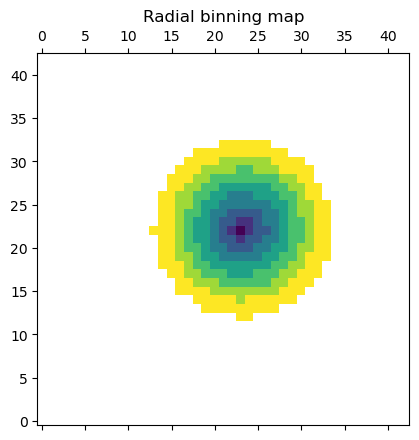

In [18]:
radial_bin_map = np.zeros((43, 43)) * np.nan


r_bins = np.array([0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.5, 0.6, 0.75]) / 0.1457 * 2
n_bins = len(r_bins) - 1

x_center, y_center = 22.23, 23.29 # 22.21855470155346, 23.282840812636806 #22, 24

print('bin boundaries', r_bins)

for i in range(radial_bin_map.shape[0]):
    for j in range(radial_bin_map.shape[1]):
        r = np.sqrt((i - x_center)**2 + (j - y_center)**2)        
#         if 0. <= r < r_bins[0]:
#             radial_bin_map[i, j] = 0
        for n in range(len(r_bins)-1):    
            if r_bins[n] <= r < r_bins[n+1]:
                radial_bin_map[i, j] = n

# radial_bin_map += 1
# radial_bin_map[x_center, y_center] = 0

# print(np.nanmax(radial_bin_map)+1, len(r_bins) - 1)

# print(radial_bin_map[x_center, y_center])

plt.matshow(radial_bin_map, origin='lower')
plt.title('Radial binning map');

## Load Voronoi binning map

In [19]:
from data_util import *

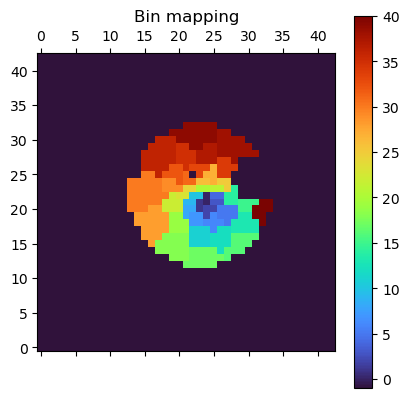

In [20]:
%matplotlib inline

bin_mapping = load_bin_mapping(target_snr_per_bin, 
                               plot=True)

In [6]:
radial_bin_map[bin_mapping == -1] = np.nan

## Make surface brightness map for weighted binning

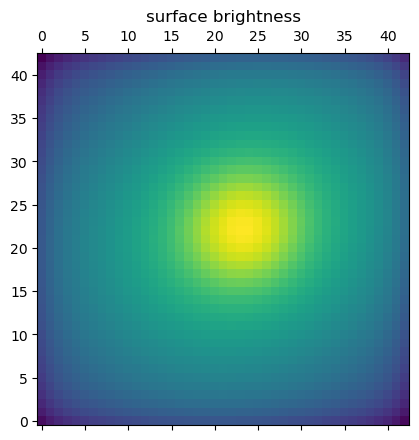

In [7]:
%matplotlib inline

from lenstronomy.LightModel.light_model import LightModel
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from dynamical_model import DynamicalModel

np.random.seed(2)
light_model = LightModel(['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])
dyn_model = DynamicalModel('powerlaw')

supersampling_factor = 5

x_grid, y_grid = dyn_model.get_supersampled_grid(supersampling_factor=supersampling_factor)

kwargs_light = dyn_model.get_double_sersic_kwargs(is_shperical=False)
#kwargs_light[0]['e2'] *= -1

num_pix = len(x_grid)

surface_brightness = light_model.surface_brightness(x_grid, 
                                                    y_grid, 
                                                    kwargs_light).reshape((num_pix, num_pix))


sigma = dyn_model.PSF_FWHM / 2.355 / dyn_model.PIXEL_SIZE * supersampling_factor

kernel = Gaussian2DKernel(x_stddev=sigma,
                          x_size=6 * int(sigma) + 1,
                          y_size=6 * int(sigma) + 1)

convolved_surface_brightness = convolve(surface_brightness, kernel)

convolved_surface_brightness_spaxel = convolved_surface_brightness.reshape(
            len(dyn_model.X_GRID), supersampling_factor,
            len(dyn_model.Y_GRID), supersampling_factor
        ).sum(3).sum(1)

plt.matshow(np.log10(convolved_surface_brightness_spaxel), origin='lower')
plt.title('surface brightness')
plt.show()

In [8]:
# should be [[22, 24]]
np.argwhere(convolved_surface_brightness_spaxel == np.max(convolved_surface_brightness_spaxel))

array([[22, 23]])

## check centring of the light distribution

Text(0.5, 1.0, 'This plot should look symmetric!')

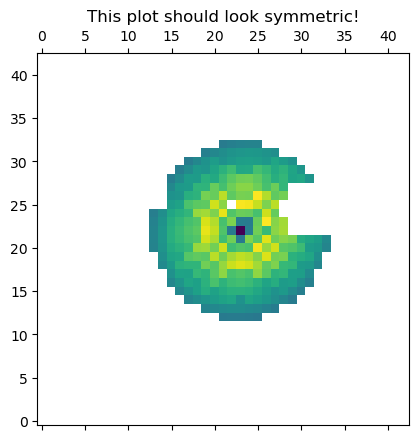

In [9]:
plt.matshow(radial_bin_map*convolved_surface_brightness_spaxel, origin='lower')
plt.title('This plot should look symmetric!')

## Make random realization in voronoi bin, then create 2D map, then bin in radial annuli

In [10]:
sample_number_for_each_setting = 200
velocity_dispersion_realizations_in_voronoi = []
velocity_dispersion_realizations_2d = []
velocity_dispersion_radially_binned = []

for rng in range(1, 4):
    for deg in range(2, 5):
        for template in range(1, 4):
            for quasar in ['A', 'B', 'C']:
                
                vd_name = 'VD_wave_rng_{}_deg_{}_global_temp_{}_quasar_sp_{}_SN_{}.txt'.format(
                    rng, deg, template, quasar, target_snr_per_bin
                )

                directory_measurements = "../kcwi_extractions/extracted_dispersions/"
                # object_name = "KCWI_RXJ1131_icubes_mosaic_0.1457"

                url = directory_measurements + vd_name

                extracted_vel_dis = np.loadtxt(url)
                
                vel_dis = extracted_vel_dis[:, 1]
                std_vel_dis = extracted_vel_dis[:, 3]
                
                
                good_bins = np.ones_like(vel_dis)
                
                if np.any(std_vel_dis > 200):
#                     print(vel_dis[std_vel_dis > 200], std_vel_dis[std_vel_dis > 200])
                    good_bins[std_vel_dis > 200] = 0
                    good_bins[std_vel_dis > 200] = 0
                
                min_val = 5
                if np.any(vel_dis < min_val):
#                     print(vel_dis[vel_dis < min_val], std_vel_dis[vel_dis < min_val])
                    good_bins[vel_dis < min_val] = 0
                    good_bins[vel_dis < min_val] = 0
                
                max_val = 700
                if np.any(vel_dis > max_val):
#                     print(vel_dis[vel_dis > max_val], std_vel_dis[vel_dis > max_val])
                    good_bins[vel_dis > max_val] = 0
                    good_bins[vel_dis > max_val] = 0
                    
                for i in range(sample_number_for_each_setting):
                    realization = np.random.normal(loc=vel_dis,
                                         scale=std_vel_dis,
#                                          size=(1, len(vel_dis))
                                        )
                    
                    realization[np.where(good_bins == 0)] = np.nan
                    
#                     cbar = plt.matshow(get_kinematics_maps(realization, bin_mapping), origin='lower', cmap='viridis')
#                     plt.colorbar(cbar)
#                     plt.show()
                    
                    map_2d = get_kinematics_maps(realization, bin_mapping)
                    velocity_dispersion_realizations_in_voronoi.append(realization)    
                    velocity_dispersion_realizations_2d.append(map_2d)
                    binned_in_r = np.zeros(int(np.nanmax(radial_bin_map) + 1))
                    
                    # plt.matshow(map_2d*radial_bin_map, origin='lower')
                    for i in range(len(binned_in_r)):
                        binned_in_r[i] = np.sqrt(
                            np.nansum(np.sign(map_2d[radial_bin_map == i])*map_2d[radial_bin_map == i]**2 * convolved_surface_brightness_spaxel[radial_bin_map == i]) 
                            / np.nansum(convolved_surface_brightness_spaxel[radial_bin_map == i]))
                        # print(i, map_2d[radial_bin_map == i])
                        # map_2d_copy = np.copy(map_2d)
                        # map_2d_copy[radial_bin_map != i] = np.nan
                        # plt.matshow(map_2d_copy, origin='lower')
                        
                    # print(binned_in_r)
                    velocity_dispersion_radially_binned.append(
                        binned_in_r
                    )
                    
                
velocity_dispersion_radially_binned = np.array(velocity_dispersion_radially_binned)
velocity_dispersion_realizations_2d = np.array(velocity_dispersion_realizations_2d)
velocity_dispersion_realizations_in_voronoi = np.array(velocity_dispersion_realizations_in_voronoi)

Text(0.5, 1.0, 'velocity dispersion in each bin')

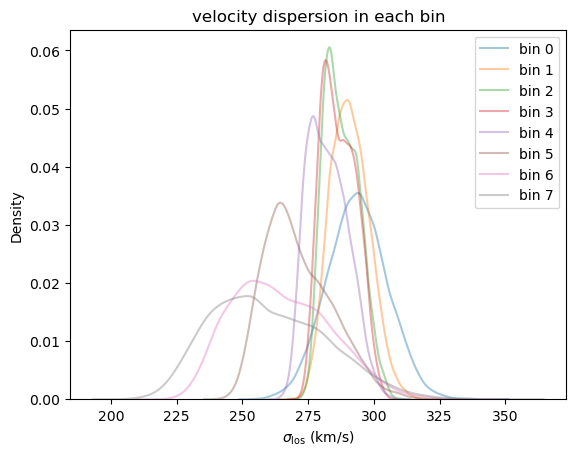

In [11]:
import seaborn as sns

ax = plt.figure().add_subplot(111)

for i in range(velocity_dispersion_radially_binned.shape[1]):
    sns.kdeplot(velocity_dispersion_radially_binned[:, i][velocity_dispersion_radially_binned[:, i] != np.nan], 
                ax=ax, alpha=0.4, label='bin {}'.format(i))

ax.set_xlabel(r'$\sigma_{\rm los}$ (km/s)')
ax.legend()
ax.set_title('velocity dispersion in each bin')

In [12]:
import numpy.ma as ma

covariance_matrix = ma.cov(ma.masked_invalid(velocity_dispersion_radially_binned), rowvar=False)

covariance_matrix.filled(np.inf);

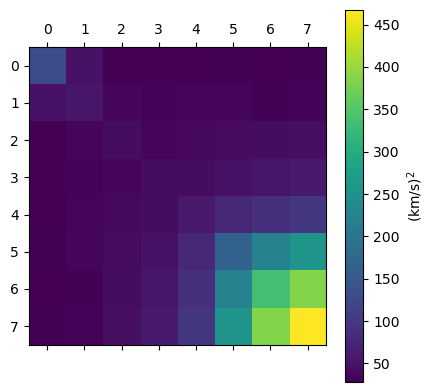

In [13]:
cbar = plt.matshow(covariance_matrix)
plt.colorbar(cbar, label=r'(km/s)${}^2$')

Text(0, 0.5, '$\\sigma_{v}$ (km/s)')

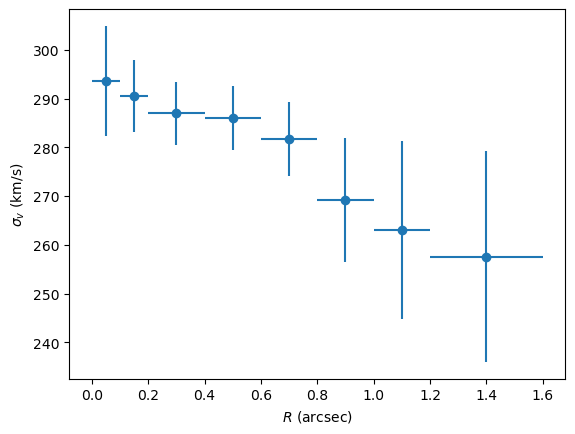

In [14]:
mean_velocity_dispersion_in_radial_bins = ma.median(ma.masked_invalid(velocity_dispersion_radially_binned), axis=0).data

plt.errorbar(x=(r_bins[:-1]+np.diff(r_bins)/2.)*0.1457, 
             y=mean_velocity_dispersion_in_radial_bins, 
             xerr=np.diff(r_bins)/2.*0.1457,
             yerr=np.sqrt(np.diag(covariance_matrix)),
             ls='None', marker='o'
            )
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$\sigma_{v}$ (km/s)')

## Check residuals in 2D map

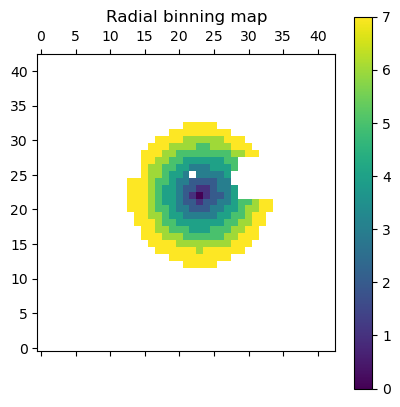

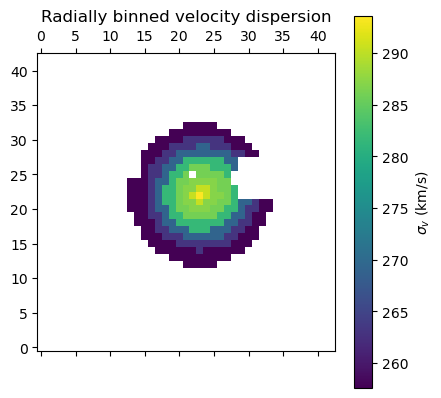

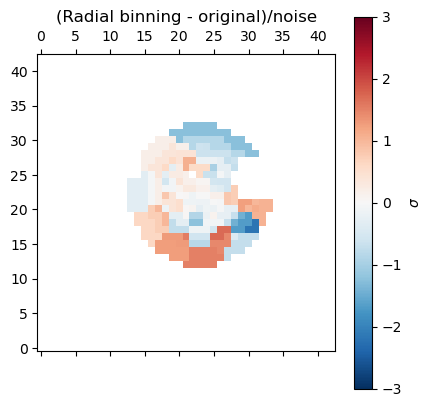

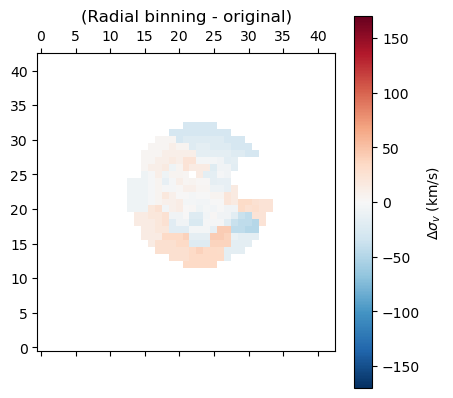

In [15]:
import numpy.ma as ma

radial_bin_mask = np.copy(radial_bin_map)
radial_bin_mask[np.isnan(radial_bin_map)] = 0

im = plt.matshow(radial_bin_map, origin='lower', cmap='viridis')
plt.colorbar(im)
plt.title('Radial binning map')
plt.show()

radially_binned_velocity_dispersion_2d_image = get_kinematics_maps(mean_velocity_dispersion_in_radial_bins,
                                                                   radial_bin_mask)
original_2d_velocity_dispersion = np.nanmean(velocity_dispersion_realizations_2d, axis=0)

original_2d_noise = ma.cov(ma.masked_invalid(velocity_dispersion_realizations_in_voronoi), rowvar=True)
original_2d_noise.filled(np.inf);
original_2d_noise = get_kinematics_maps(np.sqrt(np.diag(original_2d_noise)), 
                                radial_bin_mask)

radial_bin_mask = np.copy(radial_bin_map)
radial_bin_mask[radial_bin_map > -1] = 1
radial_bin_mask[radial_bin_map == -1] = np.nan

radial_bin_mask[original_2d_velocity_dispersion == 0] = np.nan

im = plt.matshow(radially_binned_velocity_dispersion_2d_image*radial_bin_mask, origin='lower', cmap='viridis')
plt.colorbar(im, label=r'$\sigma_{v}$ (km/s)')
plt.title('Radially binned velocity dispersion')
plt.show()

im = plt.matshow(((radially_binned_velocity_dispersion_2d_image - original_2d_velocity_dispersion)
                  /original_2d_noise)*radial_bin_mask,
                   origin='lower', cmap='RdBu_r',
                   vmax=3, vmin=-3
                  )
plt.title('(Radial binning - original)/noise')
plt.colorbar(im, label=r'$\sigma$')
plt.show()

delta_v = (radially_binned_velocity_dispersion_2d_image - original_2d_velocity_dispersion)
# delta_v[np.abs(delta_v)/original_binned_noise < 3] = 0.

im = plt.matshow(delta_v*radial_bin_mask,
                   origin='lower', cmap='RdBu_r',
                   vmax=170, vmin=-170
                  )
plt.title('(Radial binning - original)')
plt.colorbar(im, label=r'$\Delta \sigma_{v}$ (km/s)')
plt.show()

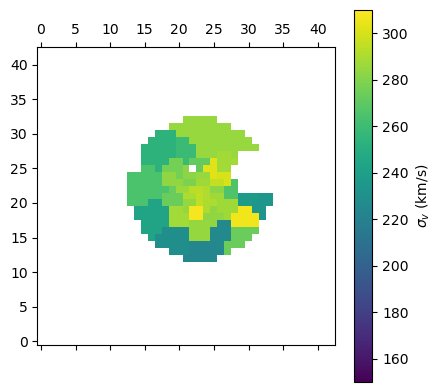

In [16]:
## original 2D dispersion map

cbar = plt.matshow(original_2d_velocity_dispersion*radial_bin_mask, origin='lower', 
                   cmap='viridis',
                   vmax=310, vmin=150
                  )
plt.colorbar(cbar, label=r'$\sigma_{v}$ (km/s)')

Text(0.5, 1.0, 'velocity dispersion in each Voronoi bin')

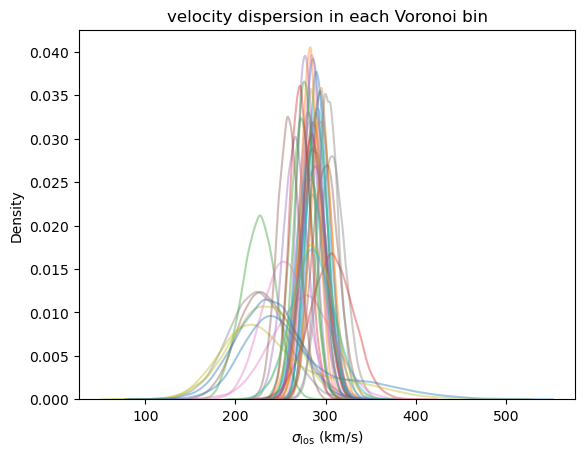

In [17]:
import seaborn as sns

ax = plt.figure().add_subplot(111)

for i in range(velocity_dispersion_realizations_in_voronoi.shape[1]):
    sns.kdeplot(velocity_dispersion_realizations_in_voronoi[:, i][velocity_dispersion_realizations_in_voronoi[:, i] != np.nan], 
                ax=ax, alpha=0.4)

ax.set_xlabel(r'$\sigma_{\rm los}$ (km/s)')
ax.set_title('velocity dispersion in each Voronoi bin')

## Save file

In [ ]:
import h5py as h5

with h5.File('/Users/ajshajib/Research/time_delay_cosmography/7LensMilestone/'
             'Likelihoods/MilestoneLikelihood/TDCOSMO_sample/TDCOSMO_data/RXJ1131-1231/rxj1131_kcwi_binned.h5', 'w') as f:
    f.create_dataset('binned_dispersion', data=mean_velocity_dispersion_in_radial_bins)
    f.create_dataset('radial_bins', data=r_bins*0.1457)
    f.create_dataset('covariance', data=covariance_matrix)